In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
# parse benchmark result files (pseudo-csv files:)) and save as csv
def parse(file):
    '''Parses benchmark result file.'''
    lines = file.readlines()
    # get the line number of the following line:
    # Operator-wise Profiling Info for Regular Benchmark Runs:
    line_number = lines.index('Operator-wise Profiling Info for Regular Benchmark Runs:\n')
    # skip the next line as it is this:
    # ============================== Run Order ==============================
    line_number += 1
    # get the nearest next line which is empty
    next_empty_line_number = lines.index('\n', line_number)

    # return all lines between
    return lines[line_number+1:next_empty_line_number]

def parse_benchmark_results(input_filepaths, output_dir):
    '''
    Reads benchmark result files and parses them. Writes the new files 
    in csv format in the output directory. Returns the list of output files.
    '''
    output_files = []
    # iterate over input files
    for filepath in input_files:
        print('Parsing:', filepath)
        
        # open the file and parse it
        with open(filepath) as f:
            lines = parse(f)
        
        # extract just the filename(without extension)
        filename = os.path.basename(filepath).rsplit('.', maxsplit=1)[0]

        # write the parsed lines to file
        output_file = os.path.join(output_dir, filename + '.csv')
        with open(output_file, 'w') as f:
            f.write('\n'.join(lines))

        # add to results list
        output_files.append(output_file)
    
    print("Outputs written to:", os.path.abspath(output_dir))
    return output_files


def abs_listdir(path):
    '''Lists absolute paths of files in a directory.'''

    # convert to absolute path
    path = os.path.abspath(path)
    return [os.path.join(path, f) for f in os.listdir(path)]

In [3]:
input_files = [f for f in abs_listdir('results/') if f.endswith('.txt')] 
csv_results = parse_benchmark_results(input_files, output_dir='results')

Parsing: /home/sobir/Desktop/dsproject/results/elu_depthwise_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/relu_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/elu_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/elu_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/relu_depthwise_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/tanh_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/elu_depthwise_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/tanh_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/relu_spatial_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/relu_depthwise_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/tanh_depthwise_benchmark.txt
Parsing: /home/sobir/Desktop/dsproject/results/tanh_depthwise_spatial_benchmark.txt
Outputs written to: /home/sobir/Desktop/dsproject/results


In [4]:
df = pd.read_csv(csv_results[1])
df

,node type,start,first,avg_ms,%,cdf%,mem KB,times called,name
0,CONV_2D,0.000000,0.100,0.097875,56.5206%,56.5206%,0,1,[sequential_10/conv2d_30/Relu]:0
1,AVERAGE_POOL_2D,0.097974,0.029,0.028477,16.445%,72.9655%,0,1,[sequential_10/average_pooling2d_20/AvgPool]:1
2,CONV_2D,0.126499,0.033,0.032459,18.7441%,91.7097%,0,1,[sequential_10/conv2d_31/Relu]:2
3,AVERAGE_POOL_2D,0.159011,0.004,0.003716,2.14597%,93.8556%,0,1,[sequential_10/average_pooling2d_21/AvgPool]:3
4,CONV_2D,0.162767,0.008,0.007803,4.50625%,98.3619%,0,1,[sequential_10/conv2d_32/Relu]:4
5,FULLY_CONNECTED,0.170638,0.002,0.002104,1.2148%,99.5767%,0,1,[sequential_10/dense_20/Relu]:5
6,FULLY_CONNECTED,0.172796,0.000,0.000390,0.224962%,99.8016%,0,1,[sequential_10/dense_21/MatMul]:6
7,SOFTMAX,0.173240,0.001,0.000344,0.198376%,100%,0,1,[Identity]:7


In [5]:
dfs = {os.path.split(r)[1] : pd.read_csv(r) for r in csv_results}
conv_time_total = {}
conv_percentage_total = {}
conv_type = {}
activation_time_total = {}
activation_percentage_total = {}
activation = {}


for filename, df in dfs.items():
    # convolution statistics
    df_convs = df[df['node type'].apply(lambda s: 'CONV' in s)]
    conv_time_total[filename] = df_convs[' avg_ms'].sum()
    conv_percentage_total[filename] = df_convs[' %'].apply(lambda s: float(s[:-1])).sum()
    conv_type[filename] = '_'.join(filename.split('_')[1:-1]) or 'regular'
    
    # activation statistics
    df_activations = df[df['node type'].apply(lambda s: s in ['ELU', 'RELU', 'TANH'])]
    activation_time_total[filename] = df_activations[' avg_ms'].sum()
    activation_percentage_total[filename] = df_activations[' %'].apply(lambda s: float(s[:-1])).sum()
    activation[filename] = filename.split('_', maxsplit=1)[0].upper()

result = pd.DataFrame({'conv_type': conv_type,
                       'conv_time_total': conv_time_total, 
                       'conv_percentage_total': conv_percentage_total,
                       'activation': activation,
                       'activation_time_total': activation_time_total,
                       'activation_percentage_total': activation_percentage_total})
result

,conv_type,conv_time_total,conv_percentage_total,activation,activation_time_total,activation_percentage_total
elu_depthwise_spatial_benchmark.csv,depthwise_spatial,0.126754,62.695360,ELU,0.039839,19.705450
relu_benchmark.csv,regular,0.138137,79.770950,RELU,0.000000,0.000000
elu_benchmark.csv,regular,0.146441,63.773710,ELU,0.046895,20.422235
elu_spatial_benchmark.csv,spatial,0.112809,57.075746,ELU,0.047722,24.144991
relu_depthwise_spatial_benchmark.csv,depthwise_spatial,0.132314,78.532923,RELU,0.000000,0.000000
tanh_benchmark.csv,regular,0.163137,75.151320,TANH,0.015003,6.911175
elu_depthwise_benchmark.csv,depthwise,0.240425,75.852880,ELU,0.041018,12.940980
tanh_spatial_benchmark.csv,spatial,0.108951,68.723257,TANH,0.013513,8.523709
relu_spatial_benchmark.csv,spatial,0.116673,75.672690,RELU,0.000000,0.000000
relu_depthwise_benchmark.csv,depthwise,0.260925,87.604805,RELU,0.000000,0.000000


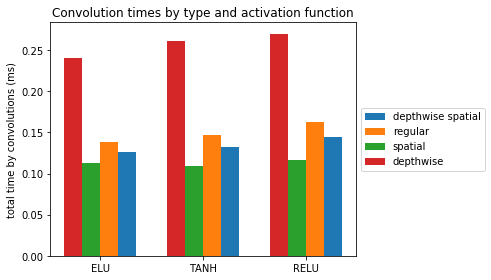

In [70]:
labels = ['ELU', 'TANH', 'RELU']
conv_types = result['conv_type'].unique()
men_means = []
women_means = []

x = np.arange(len(labels)) * 2  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = {}
mid_padding = 0.0
for i, conv_type in enumerate(conv_types):
    pos = x - ((i-2)*(1+mid_padding) + 1/2) * width
    r = result[result['conv_type'] == conv_type]
    label = conv_type.replace('_', ' ')
    rects[conv_type] = ax.bar(pos, r['conv_time_total'], width, label=label)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('total time by convolutions (ms)')
ax.set_title('Convolution times by type and activation function')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout()
plt.show()